In [2]:
%matplotlib inline

import sys
sys.path.append('/input')
import os

import numpy as np
import pandas as pd
from sklearn.externals import joblib
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

METADATA_FILEPATH = './meta/files/metadata.csv'
IMG_DIR = '/output/auxiliary_data'
IMG_DIR_MASKS =os.path.join(IMG_DIR,'masks')
AUXILIARY_METADATA_FILEPATH = '/output/auxiliary_metadata.csv'

In [6]:
import logging
import os
import pathlib
import random
import sys
import time
from itertools import chain
from collections import Iterable
import gc

import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize
import yaml


def plot_list(images=[], labels=[]):
    n_img = len(images)
    n_lab = len(labels)
    n = n_lab + n_img
    fig, axs = plt.subplots(1, n, figsize=(16, 12))
    for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    for j, label in enumerate(labels):
        axs[n_img + j].imshow(label, cmap='nipy_spectral')
        axs[n_img + j].set_xticks([])
        axs[n_img + j].set_yticks([])
    plt.show()

    
def load_image(filepath, is_mask=False):
    if is_mask:
        img = (np.array(Image.open(filepath)) > 0).astype(np.uint8)
    else:
        img = np.array(Image.open(filepath)).astype(np.uint8)
    return img


def save_image(img, filepath):
    img = Image.fromarray((img))
    img.save(filepath)


def resize_image(image, target_shape, is_mask=False):
    if is_mask:
        image = (resize(image, target_shape, preserve_range=True) > 0).astype(int)
    else:
        image = resize(image, target_shape)
    return image


def get_cut_coordinates(mask, step=4, min_img_crop=20, min_size=50, max_size=300):
    h, w = mask.shape
    ts = []
    rots = [1, 2, 3, 0]
    for rot in rots:
        mask = np.rot90(mask)
        for t in range(min_img_crop, h, step):
            crop = mask[:t, :t]
            size = crop.mean() * h * w
            if min_size < size <= max_size:
                break
        ts.append((t, rot))
    try:
        ts = [(t, r) for t, r in ts if t < 99]
        best_t, best_rot = sorted(ts, key=lambda x: x[0], reverse=True)[0]
    except IndexError:
        return (0, w), (0, h), False
    if best_t < min_img_crop:
        return (0, w), (0, h), False

    if best_rot == 0:
        x1, x2, y1, y2 = 0, best_t, 0, best_t
    elif best_rot == 1:
        x1, x2, y1, y2 = 0, best_t, h - best_t, h
    elif best_rot == 2:
        x1, x2, y1, y2 = w - best_t, w, h - best_t, h
    elif best_rot == 3:
        x1, x2, y1, y2 = w - best_t, w, 0, best_t
    else:
        raise ValueError
    return (x1, x2), (y1, y2), True

In [5]:
metadata = pd.read_csv(METADATA_FILEPATH)
metadata_train = metadata[metadata['is_train']==1]
metadata_train.head()

,file_path_image,file_path_mask,is_train,id,z
0,../input/train/images/dc0119712d.png,../input/train/masks/dc0119712d.png,1,dc0119712d,458
1,../input/train/images/7e737a6cc6.png,../input/train/masks/7e737a6cc6.png,1,7e737a6cc6,557
2,../input/train/images/f7380099f6.png,../input/train/masks/f7380099f6.png,1,f7380099f6,796
3,../input/train/images/b345b1f290.png,../input/train/masks/b345b1f290.png,1,b345b1f290,355
4,../input/train/images/7145f7e956.png,../input/train/masks/7145f7e956.png,1,7145f7e956,647


# Filter larger masks

In [7]:
sizes = []
for file_path in tqdm(metadata_train.file_path_mask):
    mask = load_image(file_path, is_mask=True)
    sizes.append(mask.sum())
    
metadata_train['size'] = sizes

metadata_large_masks = metadata_train[metadata_train['size'].between(300,8000)]
metadata_large_masks.head()

100%|██████████| 4000/4000 [00:01<00:00, 2012.50it/s]
/home/dex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,file_path_image,file_path_mask,is_train,id,z,size
1,../input/train/images/7e737a6cc6.png,../input/train/masks/7e737a6cc6.png,1,7e737a6cc6,557,920
2,../input/train/images/f7380099f6.png,../input/train/masks/f7380099f6.png,1,f7380099f6,796,6060
5,../input/train/images/3c10a71f62.png,../input/train/masks/3c10a71f62.png,1,3c10a71f62,328,2713
6,../input/train/images/8686b3a5d4.png,../input/train/masks/8686b3a5d4.png,1,8686b3a5d4,715,5944
9,../input/train/images/211dca3b80.png,../input/train/masks/211dca3b80.png,1,211dca3b80,545,4578


# Explore cut results

/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


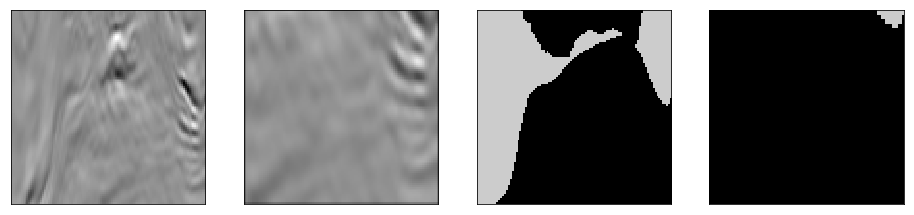

In [9]:
def present_cut(idx):
    row = metadata_large_masks.iloc[idx]
    image = load_image(row.file_path_image, is_mask=False)
    mask = load_image(row.file_path_mask, is_mask=True)
    (x1,x2),(y1,y2), was_cropped = get_cut_coordinates(mask,step=4, min_size=50, max_size=300)
    if was_cropped:
        synthetic_mask = resize_image(mask[x1:x2,y1:y2], (101,101),is_mask=True)
        synthetic_image = resize_image(image[x1:x2,y1:y2], (101,101))
        plot_list(images=[image, synthetic_image], labels=[mask, synthetic_mask])
        
present_cut(idx=18)

# Prepare synthetic data

In [7]:
!mkdir /output/auxiliary_data
!mkdir /output/auxiliary_data/masks /output/auxiliary_data/images

In [10]:
file_path_images,file_path_masks,ids, zs = [],[],[],[]
for _, row in tqdm(metadata_large_masks.iterrows()):
    image = load_image(row.file_path_image, is_mask=False)
    mask = load_image(row.file_path_mask, is_mask=True)
    (x1,x2),(y1,y2), was_cropped = get_cut_coordinates(mask,step=4, min_size=50, max_size=300)
    if was_cropped:
        synthetic_mask = resize_image(mask[x1:x2,y1:y2], (101,101),is_mask=True).astype(np.uint8)
        synthetic_image = (resize_image(image[x1:x2,y1:y2], (101,101))*255.).astype(np.uint8)
        idx = row.id
        
        file_path_image=os.path.join(IMG_DIR,'images','{}.png'.format(idx))
        file_path_mask=os.path.join(IMG_DIR,'masks','{}.png'.format(idx))
        save_image(synthetic_image, file_path_image)
        save_image(synthetic_mask, file_path_mask)
        test=load_image(file_path_mask)
    
        file_path_images.append(file_path_image)
        file_path_masks.append(file_path_mask)
        ids.append(idx)
        zs.append(row.z)

0it [00:00, ?it/s]/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



FileNotFoundError: [Errno 2] No such file or directory: '/output/auxiliary_data/images/7e737a6cc6.png'

In [9]:
metadata_small_masks = pd.DataFrame({'file_path_image':file_path_images,
                                     'file_path_mask':file_path_masks,
                                     'id':ids,
                                     'z':zs
                                    })
metadata_small_masks['is_train']=1

In [10]:
display(metadata_small_masks.shape)
metadata_small_masks.head()

(1488, 5)

,file_path_image,file_path_mask,id,z,is_train
0,/output/auxiliary_data/images/bd20d18369.png,/output/auxiliary_data/masks/bd20d18369.png,bd20d18369,513,1
1,/output/auxiliary_data/images/5aee63c515.png,/output/auxiliary_data/masks/5aee63c515.png,5aee63c515,611,1
2,/output/auxiliary_data/images/e560423302.png,/output/auxiliary_data/masks/e560423302.png,e560423302,585,1
3,/output/auxiliary_data/images/a21ae8cb6b.png,/output/auxiliary_data/masks/a21ae8cb6b.png,a21ae8cb6b,798,1
4,/output/auxiliary_data/images/eaefc56247.png,/output/auxiliary_data/masks/eaefc56247.png,eaefc56247,455,1


In [11]:
metadata_small_masks.to_csv(AUXILIARY_METADATA_FILEPATH)

In [11]:
!ls

 augmentations.ipynb	     meta
 auxiliary_metadata.csv      modules
 common_blocks		     offline_job.log
 configs		    'OpenSolution results.ipynb'
 data_exploration.ipynb      requirements.txt
 Main-folds.ipynb	     result_exploration.ipynb
'Main folds neptune.ipynb'   small_mask_generation.ipynb
 Main.ipynb		    'Untitled 1.ods'
 main.py


In [3]:
meta = pd.read_csv('auxiliary_metadata.csv')
depths = pd.read_csv('depths.csv')

In [4]:
meta = meta.merge(depths)[['file_path_image', 'z']] #.to_csv('auxiliary.csv', index = False)

In [5]:
depths.shape, meta.shape

((22000, 2), (1488, 2))

In [12]:
meta['file_path_image'] = 'aux' + meta['file_path_image']

In [14]:
meta.to_csv('auxiliary.csv', index = False)

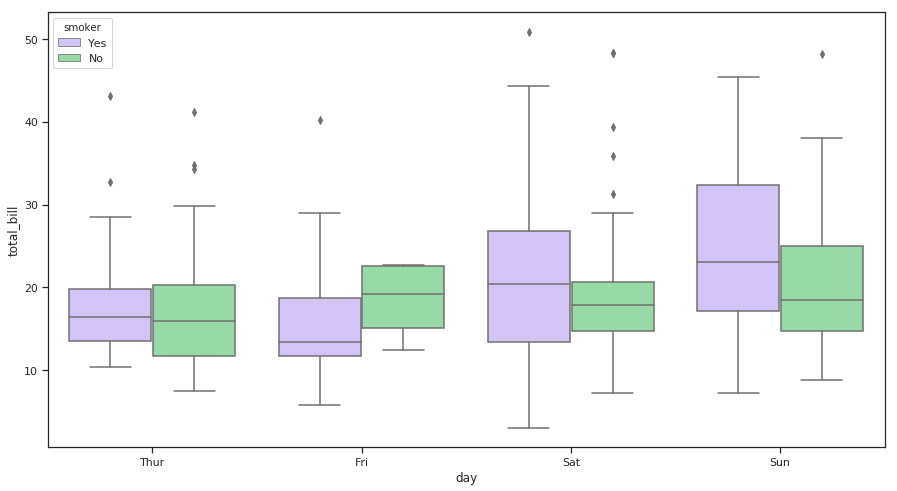

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sns.set(style="ticks", palette="pastel")
# Load the example tips dataset
tips = sns.load_dataset("tips")
plt.figure(figsize=(15,8))
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
#sns.despine(offset=10, trim=True)